In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import json
import copy

### Pour trouver le JSON rassemblant les infos des champions, aller sur https://developer.riotgames.com/docs/lol#data-dragon_champions

Enregistrer la page en JSON sous le nom "champion.json"

In [81]:
f = open('CHAMPS\\champion.json',encoding="utf8")
data = json.load(f)

In [82]:
#Rassemble les informations des champions 
info_champs = data['data']

In [83]:
#Liste des noms de tous les champions
all_champions = list(data['data'].keys())

In [84]:
#Liste des statistiques 
all_stats = list(info_champs[all_champions[52]]['stats'])
all_stats.remove("crit")
all_stats.remove("critperlevel")
relevant_stats = all_stats
print(relevant_stats)

['hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen', 'mpregenperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed']


In [85]:
#Liste de tous les tags des champions
all_tags = []
for champ in all_champions:
    for tag in info_champs[champ]['tags']:
        all_tags.append(tag)
all_tags = list(set(all_tags))
print(all_tags)

['Tank', 'Fighter', 'Assassin', 'Support', 'Marksman', 'Mage']


### Définition de l'espace vectoriel des champions

In [86]:
#Les vecteurs incluent les stats 
def make_vecteur_stats(dic_champ):
    stats = dic_champ['stats']
    return([stats[k] for k in relevant_stats])

In [87]:
Vector_space = {}
for champ in all_champions:
    Vector_space[champ] = make_vecteur_stats(info_champs[champ])

In [88]:
#Normalise les stats globalement : minmax scaler (mauvais avec la PCA ?)
def minmax_normalize(vector_space_n):
    vector_space = copy.deepcopy(vector_space_n)
    minmaxs = [[1000,0] for i in relevant_stats]
    for champ in all_champions:
        vec = vector_space[champ]
        for i in range(len(vec)):
            if minmaxs[i][0]>vec[i]:
                minmaxs[i][0] = vec[i]
            if minmaxs[i][1]<vec[i]:
                minmaxs[i][1] = vec[i]
    for champ in all_champions:
        vec = vector_space[champ]
        for i in range(len(vec)):
            vec[i] = (vec[i] - minmaxs[i][0])/(minmaxs[i][1] - minmaxs[i][0])
    return vector_space

In [89]:
Norm_Vector_space = minmax_normalize(Vector_space)

In [90]:
#Associe à chaque champion son tag définit par RIOT
tag_space = {}
for champ in all_champions:
    tag_space[champ] = info_champs[champ]['tags']

In [91]:
#Crée un vecteur avec le style one_hot qui donne du poids à chaque tag 
Vector_tags = {}
for champ in all_champions:
    vec_tag = [0 for k in range(len(all_tags))]
    tag = tag_space[champ]
    vec_tag[all_tags.index(tag[0])] = 10
    try:
        vec_tag[all_tags.index(tag[1])] = 5
        Vector_tags[champ] = vec_tag
    except:
        Vector_tags[champ] = vec_tag
print(Vector_tags['Naafiri'])

[0, 0, 10, 0, 0, 0]


In [92]:
#Concatene les vecteurs de stats et de tags
for champ in all_champions:
    Norm_Vector_space[champ] = Norm_Vector_space[champ] + Vector_tags[champ]
print(Norm_Vector_space['Naafiri'])

[0.8391608391608392, 0.85, 0.04, 0.632183908045977, 0.3333333333333333, 0.41379310344827586, 0.8545454545454546, 0.5882352941176471, 0.6551724137931034, 0.0, 0.8666666666666667, 0.5882352941176471, 0.15, 1.0, 0.46875, 0.42000000000000004, 0.35000000000000003, 0.5013333333333335, 0, 0, 10, 0, 0, 0]


In [93]:
#Tous les roles et tous les builds
role = ['top','mid','jgl','adc','sup','none']
build = ['onhit','crit','lethalite','adbruiser','tank','tanksup','apsup','apbruiser','apdps','apburst','none']

In [94]:
#JSON rassemblant les roles et les builds de chaque champ -> Mettre a jour à chaque champ et ne pas supprimer !!
f = open('CHAMPS\\handmade_stats.json',encoding="utf8")
handmade_stats = json.load(f)

In [95]:
#Commande pour actualiser le fichier handmade_stats
#with open("CHAMPS\\handmade_stats.json", "w") as outfile:
#    json.dump(handmade_stats, outfile)

In [96]:
#Construit un vecteur style one_hot avec les stats faites à la main et concatene les vecteurs 
for champ in all_champions:
    vec_hand = [0 for k in range(15)]
    i = handmade_stats[champ]
    try:
        vec_hand[role.index(i[0])] = 10
        vec_hand[build.index(i[2])+5] = 10
        if i[1]!="none":
            vec_hand[role.index(i[1])] = 5
        if i[3]!="none":
            vec_hand[build.index(i[3])+5] = 5
    except Exception as e:
        print(champ)
        print(info)
        print(e)
    if len(Norm_Vector_space[champ]) <39: 
        Norm_Vector_space[champ] = Norm_Vector_space[champ] + vec_hand
print(Norm_Vector_space['Naafiri'])

[0.8391608391608392, 0.85, 0.04, 0.632183908045977, 0.3333333333333333, 0.41379310344827586, 0.8545454545454546, 0.5882352941176471, 0.6551724137931034, 0.0, 0.8666666666666667, 0.5882352941176471, 0.15, 1.0, 0.46875, 0.42000000000000004, 0.35000000000000003, 0.5013333333333335, 0, 0, 10, 0, 0, 0, 5, 10, 0, 0, 0, 0, 0, 10, 5, 0, 0, 0, 0, 0, 0]


In [97]:
#JSON rassemblant les sorts et le style de chaque champ -> Mettre a jour à chaque champ et ne pas supprimer !!
#boost,heal,peel,cc,engage,dash,invisibilité,degat,global
f = open('CHAMPS\\handmade_sorts.json',encoding="utf8")
handmade_sorts = json.load(f)

In [98]:
#Commande pour actualiser le fichier handmade_sorts
#with open("CHAMPS\\handmade_sorts.json", "w") as outfile:
#    json.dump(handmade_sorts, outfile)

In [99]:
#Concatene les informations -> à ne faire qu'une fois ! sinon on ajoute trop d'infos
for champ in all_champions:
    Norm_Vector_space[champ] = Norm_Vector_space[champ] + handmade_sorts[champ]

In [100]:
#Conversion des strings en float
i=0
for champ in all_champions:
    for k in range(48):
        try:
            Norm_Vector_space[champ][k] = float(Norm_Vector_space[champ][k])
        except Exception as e:
            print(champ)
            print(e)
            print(i)
    i+=1

In [118]:
#Sauvegarde les infomations des champions :
#with open("CHAMPS\\norm_vector_space.json", "w") as outfile:
#    json.dump(Norm_Vector_space, outfile)

### Vérification de la cohérence des vecteurs : calcul de distance

Plus la distance est basse, plus les champions sont similaires

In [103]:
def distance(vec1,vec2):
    d = 0
    for i in range(len(vec1)):
        d+=(vec1[i]-vec2[i])**2
    return d

In [106]:
all_distances = []
for champ1 in all_champions:
    for champ2 in all_champions:
        if champ1!=champ2:
            d = distance(Norm_Vector_space[champ1],Norm_Vector_space[champ2])
            all_distances.append([champ1,champ2,d])
all_distances.sort(key = lambda x : x[-1])
all_distances = [all_distances[2*k] for k in range(len(all_distances)//2)]

In [107]:
print(all_distances)

[['Velkoz', 'Xerath', 1.505866314014804], ['Lulu', 'Renata', 1.5663446202848246], ['Darius', 'Illaoi', 1.9101732885507496], ['Sona', 'Yuumi', 2.051550627605499], ['Syndra', 'Viktor', 2.119715257683931], ['Janna', 'Sona', 2.666147716192929], ['Aphelios', 'Jinx', 2.72039673488161], ['Janna', 'Nami', 2.9447946737755775], ['Janna', 'Yuumi', 2.9813999636237964], ['Fiddlesticks', 'Neeko', 3.0310706946761083], ['Nami', 'Sona', 3.456103477640651], ['Soraka', 'Yuumi', 3.660735674380822], ['Caitlyn', 'Xayah', 4.210684943356905], ['Rammus', 'Sejuani', 4.7741802391974], ['Camille', 'Darius', 4.997566680620482], ['Draven', 'Samira', 5.09146395408437], ['Morgana', 'Zyra', 5.395679052021924], ['Nami', 'Yuumi', 5.720775116910879], ['Camille', 'Gnar', 5.771491189807803], ['Janna', 'Soraka', 5.811583025112146], ['Camille', 'Kled', 6.822069049865743], ['Sona', 'Soraka', 6.914535644992153], ['Darius', 'Garen', 6.997849331307477], ['Garen', 'Illaoi', 7.037164642677822], ['Syndra', 'Vex', 7.108532499936602]

(array([ 325.,  397.,  677.,  844.,  763., 1088., 1708., 2014., 3986.,
        1564.]),
 array([  1.50586631,  80.84653073, 160.18719516, 239.52785958,
        318.868524  , 398.20918842, 477.54985284, 556.89051726,
        636.23118168, 715.5718461 , 794.91251052]),
 <BarContainer object of 10 artists>)

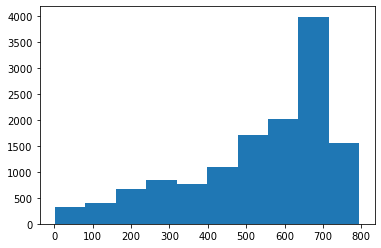

In [109]:
#Historique des distances entre les champions
dists = [a[-1] for a in all_distances]
plt.hist(dists)

In [112]:
from sklearn.cluster import KMeans
all_vecs = [Norm_Vector_space[champ] for champ in all_champions]
km = KMeans(n_clusters = 6).fit(all_vecs)
preds = km.labels_

In [110]:
def give_closest(champ):
    res = []
    for k in range(len(all_distances)):
        if all_distances[k][0] == champ or all_distances[k][1]==champ:
            res.append(all_distances[k])
    res = sorted(res,key=lambda x : x[2])[:10]
    res = [(r[0],r[1],r[2], preds[all_champions.index(r[0])], preds[all_champions.index(r[1])]) for r in res]
    res.append(preds[all_champions.index(champ)])
    return res

In [115]:
give_closest("Aphelios")

[('Aphelios', 'Jinx', 2.72039673488161, 4, 4),
 ('Aphelios', 'Lucian', 29.66490772132766, 4, 4),
 ('Aphelios', 'Sivir', 32.310205388309576, 4, 4),
 ('Aphelios', 'Tristana', 52.16901061296126, 4, 4),
 ('Aphelios', 'Xayah', 54.4533133426986, 4, 4),
 ('Aphelios', 'Kalista', 55.64773333240379, 4, 4),
 ('Aphelios', 'Caitlyn', 58.260499237597934, 4, 4),
 ('Aphelios', 'Jhin', 77.1848595983322, 4, 4),
 ('Aphelios', 'Vayne', 78.14648684878175, 4, 4),
 ('Aphelios', 'Twitch', 104.57830570793332, 4, 4),
 4]